## This project based on MAFA Dataset (https://github.com/borutb-fri/FMLD), I only get dataset and label from GDrive
- The label from FMLD_anottations sometimes isn't correct, i will adjust manually sometimes 

#### Install depedency library

In [1]:
!pip install scikit-learn
!pip install numpy
!pip install tqdm
!pip install scipy
!pip install pandas
!pip install seaborn
!pip install imblearn
!pip install gdown
!pip install opencv-python

# try to use learnable gabor feature on nn
!pip install GaborNet

In [2]:
import os
import re
import hashlib

import gdown
from tqdm import tqdm
import numpy as np
import seaborn as sns
import zipfile
from collections import Counter

import cv2
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt

# we want use undersampling for masked_face dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
# from sklearn.ensemble import RandomForestClassifier

# from sklearn.feature_selection import RFE
# from sklearn.svm import SVC
# from sklearn.model_selection import StratifiedKFold

from GaborNet import GaborConv2d

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


import glob
from xml.etree import ElementTree

2.4.0+cu124


### Download all resources

In [3]:
import hashlib

#download label from fmld_annotations
def get_file_checksum(file_path):
    sha256_hash = hashlib.sha256()
    with open(file_path, "rb") as f:
        for byte_block in iter(lambda: f.read(4096), b""):
            sha256_hash.update(byte_block)
    return sha256_hash.hexdigest()

# Expected checksum for the file
label_expected_checksum = "f0e8e2b581bb5e4fbaf20d43681f7949ef5e95100a26540c98c71d2d841d88cc"  # Replace with the actual checksum
train_expected_checksum = "201af61df08832657a8d2a6a65bc76b317aa860b922b8e7284fc0da2b6d13a46"
test_expected_checksum = "bb475f9efe2f827e606fbcf6a6a75f8654f76c6aa7ac63aee8503ed50cad5968"

filezip_label_train = './FMLD_annotations.zip'  # path fmld annotations zip file

# Path to the zip file
zip_file_path = './train-images.zip' # path train images zip file
zip_file_path_test = './test-images.zip' # path test images zip file

# Check if the file exists and its checksum (label)
if os.path.exists(filezip_label_train):
    actual_checksum = get_file_checksum(filezip_label_train)
    if actual_checksum == label_expected_checksum:
        print("File already exists and checksum matches.")
    else:
        print("File exists but checksum does not match. Downloading again.")
        gdown.download("https://github.com/borutb-fri/FMLD/raw/refs/heads/main/FMLD_annotations.zip", filezip_label_train)
else:
    print("File does not exist. Downloading.")
    gdown.download("https://github.com/borutb-fri/FMLD/raw/refs/heads/main/FMLD_annotations.zip", filezip_label_train)

# Check if the file exists and its checksum (train images)
if os.path.exists(zip_file_path):
    actual_checksum = get_file_checksum(zip_file_path)
    if actual_checksum == train_expected_checksum:
        print("File already exists and checksum matches.")
    else:
        print("File exists but checksum does not match. Downloading again.")
        !gdown 17bRIiaGyrKLEDQOV2RlqbPQ9TyCZxq9k
else:
    print("File does not exist. Downloading.")
    !gdown 17bRIiaGyrKLEDQOV2RlqbPQ9TyCZxq9k

# Check if the file exists and its checksum (test images)
if os.path.exists(zip_file_path_test):
    actual_checksum = get_file_checksum(zip_file_path_test)
    if actual_checksum == test_expected_checksum:
        print("File already exists and checksum matches.")
    else:
        print("File exists but checksum does not match. Downloading again.")
        !gdown 1jJHdmmscqxvNQ2dxKUrLaHqW3w1Yo_9S
else:
    print("File does not exist. Downloading.")
    !gdown 1jJHdmmscqxvNQ2dxKUrLaHqW3w1Yo_9S

File already exists and checksum matches.
File already exists and checksum matches.
File already exists and checksum matches.


## Unpack Label Train Images to label folder

In [4]:
# Path to the label folder
label_folder_path = './label'

# Check if the label folder exists, if not, create it
if not os.path.exists(label_folder_path):
    os.makedirs(label_folder_path)

# Check if the label folder is empty
if not os.listdir(label_folder_path):
    
    # Unpack the zip file
    with zipfile.ZipFile(filezip_label_train, 'r') as zip_ref:
        for member in tqdm(zip_ref.infolist(), desc='Extracting '):
            try:
                zip_ref.extract(member, label_folder_path)
            except zipfile.error as e:
                pass

    
    print(f'Unpacked {filezip_label_train} to {label_folder_path}')
else:
    print(f'The folder {label_folder_path} is not empty')

The folder ./label is not empty


### Patch the new label (Must!) because from dataset has wrong class classification

In [5]:
!patch -s -p0 --forward < diff.patch

Reversed (or previously applied) patch detected!  Skipping patch.
1 out of 1 hunk ignored -- saving rejects to file label/FMLD_annotations/train/train_00001314.xml.rej
Reversed (or previously applied) patch detected!  Skipping patch.
1 out of 1 hunk ignored -- saving rejects to file label/FMLD_annotations/train/train_00001389.xml.rej
Reversed (or previously applied) patch detected!  Skipping patch.
3 out of 3 hunks ignored -- saving rejects to file label/FMLD_annotations/train/train_00001906.xml.rej
Reversed (or previously applied) patch detected!  Skipping patch.
1 out of 1 hunk ignored -- saving rejects to file label/FMLD_annotations/train/train_00002018.xml.rej
Reversed (or previously applied) patch detected!  Skipping patch.
1 out of 1 hunk ignored -- saving rejects to file label/FMLD_annotations/train/train_00002019.xml.rej
Reversed (or previously applied) patch detected!  Skipping patch.
3 out of 3 hunks ignored -- saving rejects to file label/FMLD_annotations/train/train_0000203

## Unpack image dataset of face mask to image_dataset folder

In [6]:

# Directory to extract the contents to
extract_to_path = './image_dataset'

extract_to_path_test = './image_dataset_test'

# Check if the label folder exists, if not, create it
if not os.path.exists(extract_to_path):
    os.makedirs(extract_to_path)

if not os.path.exists(extract_to_path_test):
    os.makedirs(extract_to_path_test)

# Check if the label folder is empty
if not os.listdir(extract_to_path):
    # Unpack the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for member in tqdm(zip_ref.infolist(), desc='Extracting '):
                try:
                    zip_ref.extract(member, extract_to_path)
                except zipfile.error as e:
                    pass

# Check if the label folder is empty
if not os.listdir(extract_to_path_test):
    # Unpack the zip file
    with zipfile.ZipFile(zip_file_path_test, 'r') as zip_ref:
        for member in tqdm(zip_ref.infolist(), desc='Extracting '):
                try:
                    zip_ref.extract(member, extract_to_path_test)
                except zipfile.error as e:
                    pass

print(f'Unpacked {zip_file_path} to {extract_to_path}')
print(f'Unpacked {zip_file_path_test} to {extract_to_path_test}')

Unpacked ./train-images.zip to ./image_dataset
Unpacked ./test-images.zip to ./image_dataset_test


## Read train image path and annotations file on label/FMLD_annotations/train

In [7]:
# Directory containing the images
image_folder_path = extract_to_path + "/images"
anotation_folder_path = './label/FMLD_annotations/train'

image_folder_path_test = extract_to_path_test + "/images"
annotation_folder_path_test = './label/FMLD_annotations/test'

# List to store image file paths
image_files = []
image_files_test = []

# Iterate over the files in the directory
for file_name in os.listdir(image_folder_path):
    if file_name.endswith('.jpg') or file_name.endswith('.png'):
        image_files.append(os.path.join(image_folder_path, file_name))

for file_name in os.listdir(image_folder_path_test):
    if file_name.endswith('.jpg') or file_name.endswith('.png'):
        image_files_test.append(os.path.join(image_folder_path_test, file_name))

#sorting the image files
image_files = sorted(image_files)
image_files_test = sorted(image_files_test)

#creating pandas dataframe
image_df = pd.DataFrame(image_files, columns=['image_path'])
image_df["anotation_xml"] = image_df["image_path"].apply(lambda x: x.replace("image_dataset", "label")
                                                         .replace("images", "FMLD_annotations/train")
                                                         .replace(".jpg", ".xml").replace(".png", ".xml"))
display(image_df)

#creating pandas dataframe
image_test_df = pd.DataFrame(image_files_test, columns=['image_path'])
image_test_df["anotation_xml"] = image_test_df["image_path"].apply(lambda x: x.replace("image_dataset_test", "label")
                                                         .replace("images", "FMLD_annotations/test")
                                                         .replace(".jpg", ".xml").replace(".png", ".xml"))
display(image_test_df)
# raise ValueError("Stop here")

,image_path,anotation_xml
0,./image_dataset/images/train_00000001.jpg,./label/FMLD_annotations/train/train_00000001.xml
1,./image_dataset/images/train_00000002.jpg,./label/FMLD_annotations/train/train_00000002.xml
2,./image_dataset/images/train_00000003.jpg,./label/FMLD_annotations/train/train_00000003.xml
3,./image_dataset/images/train_00000004.jpg,./label/FMLD_annotations/train/train_00000004.xml
4,./image_dataset/images/train_00000005.jpg,./label/FMLD_annotations/train/train_00000005.xml
...,...,...
25871,./image_dataset/images/train_00025872.jpg,./label/FMLD_annotations/train/train_00025872.xml
25872,./image_dataset/images/train_00025873.jpg,./label/FMLD_annotations/train/train_00025873.xml
25873,./image_dataset/images/train_00025874.jpg,./label/FMLD_annotations/train/train_00025874.xml
25874,./image_dataset/images/train_00025875.jpg,./label/FMLD_annotations/train/train_00025875.xml


,image_path,anotation_xml
0,./image_dataset_test/images/test_00000001.jpg,./label/FMLD_annotations/test/test_00000001.xml
1,./image_dataset_test/images/test_00000002.jpg,./label/FMLD_annotations/test/test_00000002.xml
2,./image_dataset_test/images/test_00000003.jpg,./label/FMLD_annotations/test/test_00000003.xml
3,./image_dataset_test/images/test_00000004.jpg,./label/FMLD_annotations/test/test_00000004.xml
4,./image_dataset_test/images/test_00000005.jpg,./label/FMLD_annotations/test/test_00000005.xml
...,...,...
4930,./image_dataset_test/images/test_00004931.jpg,./label/FMLD_annotations/test/test_00004931.xml
4931,./image_dataset_test/images/test_00004932.jpg,./label/FMLD_annotations/test/test_00004932.xml
4932,./image_dataset_test/images/test_00004933.jpg,./label/FMLD_annotations/test/test_00004933.xml
4933,./image_dataset_test/images/test_00004934.jpg,./label/FMLD_annotations/test/test_00004934.xml


In [8]:
# specific_image_path = './image_dataset/images/train_00014917.jpg'
# specific_row = image_df[image_df['image_path'] == specific_image_path]
# display(specific_row)

In [9]:
# image_df["image_path"].iloc()[1]

### Parsing xml file anotations to get face segmentation information

In [10]:


def parsing_xml_annotations(image_df):
    information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'image_path': []} #Information we are extracting from the files
    iteration = 0
    for annotation in image_df['anotation_xml']:
        tree = ElementTree.parse(annotation)
        for element in tree.iter():

            if 'object' in element.tag:
                for attribute in list(element):
                    if 'name' in attribute.tag:                    
                        name = attribute.text
                        information['label'] += [name]
                        information['file'] += [annotation.split('/')[-1][0:-4]]
                        information['image_path'] += [image_df['image_path'].iloc()[iteration]]

                    if 'bndbox' in attribute.tag:
                        for dimension in list(attribute):
                            if 'xmin' in dimension.tag:
                                xmin = int(round(float(dimension.text)))
                                information['xmin'] += [xmin]
                            if 'ymin' in dimension.tag:
                                ymin = int(round(float(dimension.text)))
                                information['ymin'] += [ymin]
                            if 'xmax' in dimension.tag:
                                xmax = int(round(float(dimension.text)))
                                information['xmax'] += [xmax]
                            if 'ymax' in dimension.tag:
                                ymax = int(round(float(dimension.text)))
                                information['ymax'] += [ymax]
        iteration += 1
    return pd.DataFrame(information)


#delete image_df because the information moving to xml_info_df
#del image_df


#### Dari keseluruhan anotasi, seleksi di dataset yang ukuran anotasinya harus diatas 128x128, jika tidak maka tidak dipilih

In [11]:
#creating pandas from dict variable
xml_info_df = parsing_xml_annotations(image_df)
xml_info_df_test = parsing_xml_annotations(image_test_df)

del image_df
del image_test_df
# display(xml_info_df)


# filtering the dataset only with width and height min is 100 pixels
# Assuming xml_info_df is your DataFrame and it has 'width' and 'height' columns
threshold_width = 128  # Replace with your threshold value for width
threshold_height = 128  # Replace with your threshold value for height

xml_info_df = xml_info_df[(xml_info_df['xmax']-xml_info_df['xmin'] >= threshold_width) & (xml_info_df['ymax']-xml_info_df['ymin'] >= threshold_height)]
xml_info_df_test = xml_info_df_test[(xml_info_df_test['xmax']-xml_info_df_test['xmin'] >= threshold_width) & (xml_info_df_test['ymax']-xml_info_df_test['ymin'] >= threshold_height)]
# on test file we need drop the invalid class label
xml_info_df_test = xml_info_df_test[xml_info_df_test['label'] != 'invalid_face']

# Print the filtered DataFrame
display(xml_info_df)
display(xml_info_df_test)

,xmin,ymin,xmax,ymax,label,file,image_path
2,56,170,241,355,masked_face,train_00000003,./image_dataset/images/train_00000003.jpg
7,6,32,172,198,unmasked_face,train_00000008,./image_dataset/images/train_00000008.jpg
9,123,109,295,281,unmasked_face,train_00000010,./image_dataset/images/train_00000010.jpg
21,53,204,186,337,masked_face,train_00000022,./image_dataset/images/train_00000022.jpg
22,61,145,233,317,unmasked_face,train_00000023,./image_dataset/images/train_00000023.jpg
...,...,...,...,...,...,...,...
29388,26,9,165,148,masked_face,train_00025823,./image_dataset/images/train_00025823.jpg
29401,7,2,148,143,incorrectly_masked_face,train_00025836,./image_dataset/images/train_00025836.jpg
29412,38,19,167,148,masked_face,train_00025846,./image_dataset/images/train_00025846.jpg
29413,23,3,167,147,unmasked_face,train_00025847,./image_dataset/images/train_00025847.jpg


,xmin,ymin,xmax,ymax,label,file,image_path
0,2694,1211,3047,1564,masked_face,test_00000001,./image_dataset_test/images/test_00000001.jpg
3,113,95,339,321,masked_face,test_00000002,./image_dataset_test/images/test_00000002.jpg
4,352,114,503,265,masked_face,test_00000003,./image_dataset_test/images/test_00000003.jpg
5,799,217,938,356,unmasked_face,test_00000003,./image_dataset_test/images/test_00000003.jpg
32,305,342,764,801,masked_face,test_00000019,./image_dataset_test/images/test_00000019.jpg
...,...,...,...,...,...,...,...
10333,135,51,420,336,masked_face,test_00004931,./image_dataset_test/images/test_00004931.jpg
10334,38,120,323,405,masked_face,test_00004932,./image_dataset_test/images/test_00004932.jpg
10335,80,121,325,366,masked_face,test_00004933,./image_dataset_test/images/test_00004933.jpg
10336,148,266,424,542,masked_face,test_00004934,./image_dataset_test/images/test_00004934.jpg


Get original usage info dataset from FaceMask (MAFA)

train labels count  {'masked_face': 10325, 'unmasked_face': 1208, 'incorrectly_masked_face': 434}
test labels count  {'masked_face': 2198, 'unmasked_face': 470, 'incorrectly_masked_face': 109}


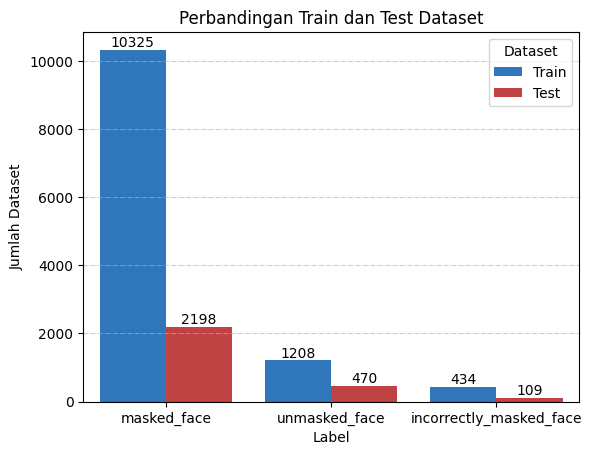

In [12]:
train_class_counts = {}
for label in xml_info_df['label']:
    train_class_counts[label] = train_class_counts.get(label, 0) + 1

print("train labels count ",train_class_counts)

test_class_counts = {}
for label in xml_info_df_test['label']:
    test_class_counts[label] = test_class_counts.get(label, 0) + 1

print("test labels count ",test_class_counts)


flatui = ["#1976d2", "#d32f2f"]

# Convert data to DataFrame for easier plotting
df = pd.DataFrame({
    'Label': train_class_counts.keys(),
    'Train': train_class_counts.values(),
    'Test': test_class_counts.values()
})

# Melt the DataFrame to long format
df_melted = df.melt(id_vars='Label', var_name='Dataset', value_name='Count')

# Create grouped bar plot
flatui = ["#1976d2", "#d32f2f"]
plot = sns.barplot(
    x='Label', 
    y='Count', 
    hue='Dataset', 
    data=df_melted, 
    palette=flatui
)

# Add bar labels
for i in plot.containers:
    plot.bar_label(i, fmt='%d')

# Customize the plot
plot.set_title("Perbandingan Train dan Test Dataset")
plot.set_ylabel("Jumlah Dataset")
plot.set_xlabel("Label")
plot.grid(axis='y', linestyle='-.', linewidth=0.5)

# Show the plot
plt.show()
# plot = sns.countplot(x=xml_info_df.label, 
#                      hue=xml_info_df.label,
#                      palette=flatui, 
#                      orient = 'v',
#                      order=["masked_face", "incorrectly_masked_face", "unmasked_face"],
#                      width=0.4)
# for i in plot.containers:
#     plot.bar_label(i, fmt='%d', label_type='edge')
# plot.grid(axis='y', linestyle='-.', linewidth=0.5)
# plot.set_ylabel("Jumlah")
# plot.set_xlabel("Kelas")
# # plot.set_xticks(np.arange(0, 11, 1), minor=False)
# plot.set_title("Jumlah dataset tiap kelas \n (setelah seleksi threshold anotasi)")

Balancing the masked_face dataset number using RandomUnderSampling imblearn and incorrectly_masked_face and unmasked_face using oversampling technique RandomOverSamping

In [13]:
# Assuming xml_info_df is your DataFrame and 'label' is the column with class labels
X = xml_info_df.drop('label', axis=1)  # Features
y = xml_info_df['label']  # Labels

desired_count = 2000

# Get the count of each class
class_counts = Counter(y)

# get the class with the maximum count and minimum count
max_class_name = max(class_counts, key=class_counts.get)
min_class_name = min(class_counts, key=class_counts.get)

# Remove the 'masked_face' class as higher count from the counter
class_counts.pop(max_class_name, None)

class_counts.pop(min_class_name, None)
med_class_name = min(class_counts, key=class_counts.get)
# Determine the desired count as the maximum count of the other classes
# desired_count = max(class_counts.values())

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy={str(max_class_name): desired_count}, random_state=42)
ros = RandomOverSampler(sampling_strategy={str(min_class_name): desired_count}, random_state=42)
ros2 = RandomOverSampler(sampling_strategy={str(med_class_name): desired_count}, random_state=42)

# Apply the undersampler
X_res, y_res = rus.fit_resample(X, y)
X_ros, y_ros = ros.fit_resample(X_res, y_res)
X_ros2, y_ros2 = ros2.fit_resample(X_ros, y_ros)

# Print the class distribution after undersampling
print(f"Resampled class distribution: {Counter(y_ros2)}")

# Combine the resampled features and labels back into a DataFrame
resampled_df = X_ros2.copy()
resampled_df['label'] = y_ros2

##########################################################################


Resampled class distribution: Counter({'incorrectly_masked_face': 2000, 'masked_face': 2000, 'unmasked_face': 2000})


## new Balancing dataset graph

Text(0.5, 1.0, 'Jumlah dataset tiap label')

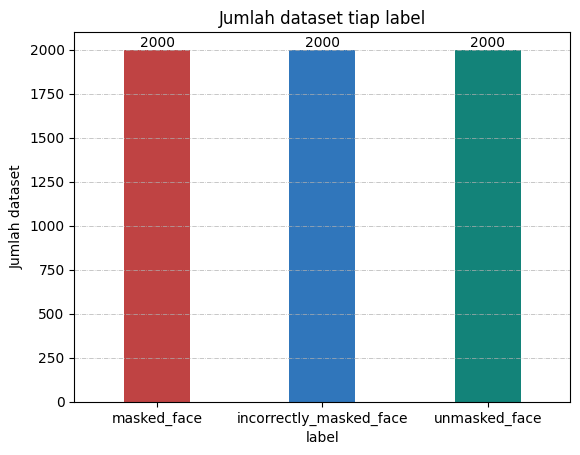

In [14]:
flatui = ["#1976d2", "#d32f2f", "#009688"]
plot = sns.countplot(x=resampled_df.label, 
                     hue=resampled_df.label,
                     palette=flatui, 
                     orient = 'v',
                     order=["masked_face", "incorrectly_masked_face", "unmasked_face"],
                     width=0.4)
for i in plot.containers:
    plot.bar_label(i, fmt='%d', label_type='edge')
plot.grid(axis='y', linestyle='-.', linewidth=0.5)
plot.set_ylabel("Jumlah dataset")
# plot.set_xticks(np.arange(0, 11, 1), minor=False)
plot.set_title("Jumlah dataset tiap label")
# raise ValueError("Stop right there!")

Manual Checking to makesure data correctly using save to csv file

In [15]:
resampled_df.to_csv('./dataset_balance.csv')

Delete old dataframe (because we don't need again) $\\$
If use don't want balancing, just comment this code

In [16]:
del xml_info_df
use_resampled_df = True
display(resampled_df)

,xmin,ymin,xmax,ymax,file,image_path,label
0,92,73,232,213,train_00000080,./image_dataset/images/train_00000080.jpg,incorrectly_masked_face
1,100,68,273,241,train_00000082,./image_dataset/images/train_00000082.jpg,incorrectly_masked_face
2,241,213,480,452,train_00001057,./image_dataset/images/train_00001057.jpg,incorrectly_masked_face
3,372,144,603,375,train_00001058,./image_dataset/images/train_00001058.jpg,incorrectly_masked_face
4,367,293,590,516,train_00001059,./image_dataset/images/train_00001059.jpg,incorrectly_masked_face
...,...,...,...,...,...,...,...
5995,167,251,524,608,train_00017305,./image_dataset/images/train_00017305.jpg,unmasked_face
5996,252,187,457,392,train_00020511,./image_dataset/images/train_00020511.jpg,unmasked_face
5997,259,296,394,431,train_00016714,./image_dataset/images/train_00016714.jpg,unmasked_face
5998,85,66,215,196,train_00018322,./image_dataset/images/train_00018322.jpg,unmasked_face


Cropping the faces from the images by using the infomation on the annotations. $\\$
The opencv2 read image then convert to grayscale

In [17]:
if (os.path.exists("preprocess_img")):
    !rm -rf preprocess_img

dataset_df = resampled_df if use_resampled_df else xml_info_df
for i in tqdm(range(len(dataset_df)), desc="Cropping images"):
    # Get The File Path and Read The Image
    image_filepath = dataset_df['image_path'].iloc[i]
    img = cv2.imread(image_filepath)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Set The Cropped Image File Name
    cropped_image_filename = dataset_df['file'].iloc[i] + '-' + str(i) + '.png'

    # Get The xmin, ymin, xmax, ymax Value (Bounding Box) to Crop Image
    xmin = dataset_df['xmin'].iloc[i]
    ymin = dataset_df['ymin'].iloc[i]
    xmax = dataset_df['xmax'].iloc[i]
    ymax = dataset_df['ymax'].iloc[i]

    # Crop The Image Based on The Values Above
    cropped_image = gray_img[ymin:ymax, xmin:xmax]

    # Save Cropped Image
    saving_folder = './preprocess_img/'+ dataset_df['label'].iloc[i]
    if not os.path.exists(saving_folder):
        os.makedirs(saving_folder)
    cv2.imwrite(saving_folder + "/" + cropped_image_filename, cropped_image)

# delete old pandas dataframe to freeing memory
del dataset_df
del resampled_df

Cropping images: 100%|██████████| 6000/6000 [00:29<00:00, 203.96it/s]


Cropping the faces (TEST IMAGES) from the images by using the infomation on the annotations. $\\$
The opencv2 read image then convert to grayscale

In [18]:
if (os.path.exists("preprocess_img_test")):
    !rm -rf preprocess_img_test

for i in tqdm(range(len(xml_info_df_test)), desc="Cropping test images"):
    # Get The File Path and Read The Image
    image_filepath = xml_info_df_test['image_path'].iloc[i]
    img = cv2.imread(image_filepath)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Set The Cropped Image File Name
    cropped_image_filename = xml_info_df_test['file'].iloc[i] + '-' + str(i) + '.png'

    # Get The xmin, ymin, xmax, ymax Value (Bounding Box) to Crop Image
    xmin = xml_info_df_test['xmin'].iloc[i]
    ymin = xml_info_df_test['ymin'].iloc[i]
    xmax = xml_info_df_test['xmax'].iloc[i]
    ymax = xml_info_df_test['ymax'].iloc[i]

    # Crop The Image Based on The Values Above
    cropped_image = gray_img[ymin:ymax, xmin:xmax]

    # Save Cropped Image
    saving_folder = './preprocess_img_test/'+ xml_info_df_test['label'].iloc[i]
    if not os.path.exists(saving_folder):
        os.makedirs(saving_folder)
    cv2.imwrite(saving_folder + "/" + cropped_image_filename, cropped_image)

# delete old pandas dataframe to freeing memory
del xml_info_df_test

# raise ValueError("Stop right there!")

Cropping test images:  55%|█████▍    | 1514/2777 [00:07<00:07, 163.47it/s]libpng warning: sBIT: invalid
libpng warning: sBIT: invalid
Cropping test images: 100%|██████████| 2777/2777 [00:13<00:00, 205.53it/s]


In [19]:
from sklearn.preprocessing import LabelEncoder

## Create Pytorch Dataset
dataset_dir = "./preprocess_img"
test_dataset_dir = "./preprocess_img_test"

class CustomImageDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        """
        Args:
            dataset_dir (str): Path ke folder dataset. Struktur folder harus berbasis class label.
            transform (callable, optional): Transformasi gambar.
        """
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(dataset_dir))

        # Load semua path gambar dan label
        for class_idx, class_name in enumerate(self.class_names):
            class_folder = os.path.join(dataset_dir, class_name)
            if not os.path.isdir(class_folder):
                continue

            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                self.image_paths.append(image_path)
                self.labels.append(class_name)

        # Encode labels to integers
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load gambar
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("L") # convert to grayscale from image PIL Lib

        # Terapkan transformasi jika ada
        if self.transform:
            image = self.transform(image)

        return image, label

# Fungsi untuk mengubah batch DataLoader menjadi numpy arrays
def dataloader_to_numpy(dataloader):
    X, y = [], []
    for images, labels in dataloader:
        # Convert PyTorch Tensors ke numpy arrays
        X.append(images.view(images.size(0), -1).numpy())  # Flatten images
        y.append(labels.numpy())
    return np.vstack(X), np.hstack(y)  # Gabungkan semua batch


# Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize ke ukuran 128x128
    transforms.ToTensor(),           # Konversi ke Tensor
    transforms.Normalize(mean=0.5, 
                         std=0.5)   # Normalisasi nilai pixel ke rentang [-1, 1]
])

# Load dataset
dataset = CustomImageDataset(dataset_dir=dataset_dir, transform=transform)
test_dataset = CustomImageDataset(dataset_dir=test_dataset_dir, transform=transform)

# DataLoader untuk melatih model
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# X_train, y_train = dataloader_to_numpy(dataloader)
# X_test, y_test = dataloader_to_numpy(test_dataloader)


In [20]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")


class GaborNN(nn.Module):
    def __init__(self):
        super(GaborNN, self).__init__()
        self.gabor_layer = GaborConv2d(in_channels=1, out_channels=32, kernel_size=(5, 5))
        self.network = nn.Sequential(
            self.gabor_layer,
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(32, 64, kernel_size=(3, 3)),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(64 * 13 * 13, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

    def get_gabor_params(self):
        return {
            'frequency': self.gabor_layer.freq, # same as lambda
            'sigma': self.gabor_layer.sigma,
            'theta': self.gabor_layer.theta,
            'phase_offset': self.gabor_layer.psi
        }



/home/rizqi/irl_project/irl_env/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Train Gabor-CNN Network

In [21]:
myModel = GaborNN().to(device)
loss_function = nn.CrossEntropyLoss()

optimizer = th.optim.Adam(myModel.parameters(), lr = 1e-3)

def train(epoch):
    myModel.train()

    train_loss = 0

    for batch_idx, (data,label) in enumerate(dataloader):

        optimizer.zero_grad()

        out = myModel(data)
        loss = loss_function(out, label)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))

for epoch in range(1, 10): # 10 epoch maybe enough
    train(epoch)


/home/rizqi/irl_project/irl_env/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Train Epoch: 1 [0/6000 (0%)]	Loss: 0.034295
Train Epoch: 1 [3200/6000 (53%)]	Loss: 0.030177
====> Epoch: 1 Average loss: 0.0295
Train Epoch: 2 [0/6000 (0%)]	Loss: 0.027509
Train Epoch: 2 [3200/6000 (53%)]	Loss: 0.021793
====> Epoch: 2 Average loss: 0.0250
Train Epoch: 3 [0/6000 (0%)]	Loss: 0.025993
Train Epoch: 3 [3200/6000 (53%)]	Loss: 0.023681
====> Epoch: 3 Average loss: 0.0232
Train Epoch: 4 [0/6000 (0%)]	Loss: 0.021023
Train Epoch: 4 [3200/6000 (53%)]	Loss: 0.018909
====> Epoch: 4 Average loss: 0.0217
Train Epoch: 5 [0/6000 (0%)]	Loss: 0.020605
Train Epoch: 5 [3200/6000 (53%)]	Loss: 0.019044
====> Epoch: 5 Average loss: 0.0209
Train Epoch: 6 [0/6000 (0%)]	Loss: 0.020537
Train Epoch: 6 [3200/6000 (53%)]	Loss: 0.018442
====> Epoch: 6 Average loss: 0.0204
Train Epoch: 7 [0/6000 (0%)]	Loss: 0.019887
Train Epoch: 7 [3200/6000 (53%)]	Loss: 0.022422
====> Epoch: 7 Average loss: 0.0201
Train Epoch: 8 [0/6000 (0%)]	Loss: 0.017330
Train Epoch: 8 [3200/6000 (53%)]	Loss: 0.020205
====> Epoch:

### Try the validation data of training result

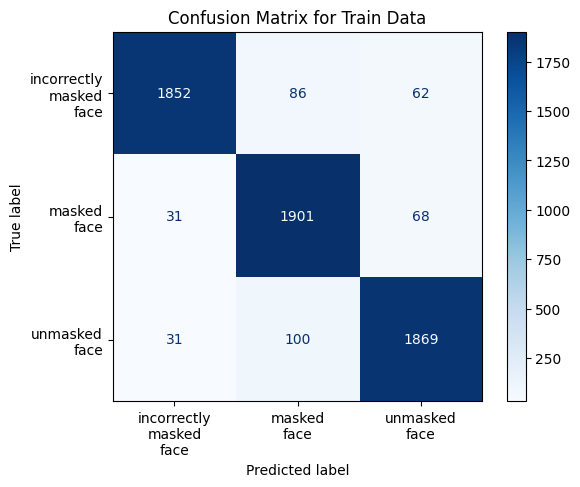

Classification Report:
               precision    recall  f1-score   support

 incorrectly       0.97      0.93      0.95      2000
  maskedface       0.91      0.95      0.93      2000
unmaskedface       0.93      0.93      0.93      2000

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



In [36]:
# Set the model to evaluation mode
myModel.eval()

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Disable gradient calculation for inference
with th.no_grad():
    for data, label in dataloader:
        data, label = data.to(device), label.to(device)
        output = myModel(data)
        _, predicted = th.max(output, 1)
        true_labels.extend(label.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['incorrectly\nmasked\nface', 'masked\nface', 'unmasked\nface'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Train Data')
plt.show()
# Generate the classification report
report = classification_report(true_labels, predictions, target_names=['incorrectly', 'maskedface', 'unmaskedface'])
print("Classification Report:\n", report)

### Try with test data... Good Luck, Ayang :)

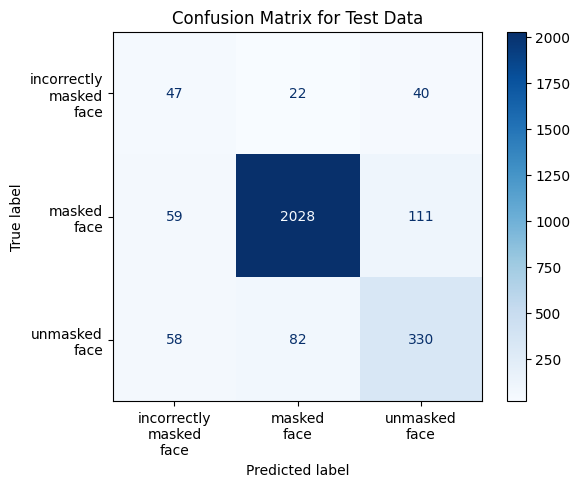

Classification Report:
               precision    recall  f1-score   support

 incorrectly       0.29      0.43      0.34       109
  maskedface       0.95      0.92      0.94      2198
unmaskedface       0.69      0.70      0.69       470

    accuracy                           0.87      2777
   macro avg       0.64      0.69      0.66      2777
weighted avg       0.88      0.87      0.87      2777



In [37]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.metrics import classification_report

# Set the model to evaluation mode
myModel.eval()

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Disable gradient calculation for inference
with th.no_grad():
    for data, label in test_dataloader:
        data, label = data.to(device), label.to(device)
        output = myModel(data)
        _, predicted = th.max(output, 1)
        true_labels.extend(label.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['incorrectly\nmasked\nface', 'masked\nface', 'unmasked\nface'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Data')
plt.show()
# Generate the classification report
report = classification_report(true_labels, predictions, target_names=['incorrectly', 'maskedface', 'unmaskedface'])
print("Classification Report:\n", report)

### Get gabor parameter after trained by Gabor-CNN Net

In [ ]:
params = myModel.get_gabor_params()

for param in params:
    print(f"{param}: {params[param]} with shape :{params[param].shape}")


## The conclusion is the model is good enough for face_masked and face unmasked class, and then
## The size of params is 32 array because i output to neural network is 32 channel on first GaborConv2d class on GaborNN Class....
## Hope you can understand the code and the result, thank you for your attention

frequency: Parameter containing:
tensor([[1.1524],
        [0.8055],
        [0.8018],
        [1.4931],
        [0.7679],
        [1.1347],
        [0.5861],
        [0.3959],
        [1.4767],
        [1.4735],
        [0.4103],
        [1.1414],
        [1.5031],
        [0.5205],
        [0.7159],
        [1.6218],
        [0.3819],
        [0.5612],
        [0.5213],
        [1.4841],
        [0.7385],
        [1.0934],
        [0.7876],
        [0.9783],
        [0.7423],
        [1.0958],
        [0.5462],
        [1.6145],
        [0.7371],
        [1.5980],
        [0.7239],
        [0.5409]], requires_grad=True) with shape :torch.Size([32, 1])
sigma: Parameter containing:
tensor([[2.7480],
        [3.9638],
        [3.9445],
        [1.8938],
        [3.8682],
        [2.7315],
        [5.5574],
        [7.9045],
        [1.8442],
        [1.8833],
        [7.8330],
        [2.7872],
        [1.8596],
        [5.5325],
        [3.7564],
        [1.9536],
        [7.8807],
   

In [24]:
# def feature_extraction(dataset):
#     image_dataset = pd.DataFrame()
#     for img in range(dataset.shape[0]):
#         df = pd.DataFrame()
#         input_img = dataset[img,:].reshape(128,128)
#         image = input_img

#         pixel_values = image.reshape(-1) #Getting the pixel values for the images
#         df['Pixel Values'] = [np.round(pixel_values,3)] #Adding the pixel values of the image to the dataframe (cropped until 3 decimal value)

#         #Gabor Filter parameters is same as the paper : https://doi.org/10.1007/s12530-021-09393-2
#         # paper is "A novel approach for face expression recognition based on Gabor filter and genetic algorithm"
#         num = 1  #To count numbers up in order to give Gabor features a label in the data frame
#         kernels = []
#         orientations = [np.pi/5, 3*np.pi/5, 4*np.pi/5]  # List of orientations to be used
#         sigmas = [3]  # List of sigma values to be used
#         lambdas = [0.4, 0.8]
#         for orientation in orientations:  # Iterate over each orientation
#             for sigma in sigmas:  # Iterate over each sigma value
#                 for lambd in lambdas:
#                     theta_radians = orientation  # Convert degrees to radians
#                     gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                     ksize=3
#                     kernel = cv2.getGaborKernel(ksize=(ksize, ksize), # k of the gabor filter
#                                                 sigma=sigma,    # std of gaussian envelope
#                                                 theta=theta_radians, # orientation of the filter in degrees
#                                                 lambd=lambd, # wavelength of sinusoidal factor
#                                                 gamma=1, # spatial aspect ratio (default=0.5)
#                                                 psi=np.pi/2, # phase offset (default=0)
#                                                 ktype=cv2.CV_32F)
#                     kernels.append(kernel)
#                     #Now filter the image and add values to a new column
#                     fimg = cv2.filter2D(image, cv2.CV_32F, kernel)
#                     filtered_img = fimg.reshape(-1)
#                     # plt.imshow(image, cmap='gray')
#                     # plt.imshow(fimg, cmap='gray')
#                     df[gabor_label] = [filtered_img]  #Labels columns as Gabor1, Gabor2, etc.
#                     num += 1  #Increment for gabor column label


#         # i changed this code because new pandas not compatible append code
#         # image_dataset = image_dataset.append(df)
#         image_dataset = pd.concat([image_dataset, pd.DataFrame(df)], ignore_index=True)
#     return image_dataset


# image_features = feature_extraction(X_train)

#### The class number meaning :
- 0 is incorrectly_masked_face
- 1 is masked_face (correctly)
- 2 is unmasked_face

In [25]:
# index_img = 0

# # show examples after gabor filtering from index_img
# print(f"{image_features.iloc()[index_img]=}")
# plt.figure(figsize=(20, 20))  # Ukuran figure
# for i in range(len(image_features.iloc()[index_img].keys())):  # Karena ada 6 gambar
#     plt.subplot(3, 5, i + 1)  # Baris=2, Kolom=3, indeks dimulai dari 1
#     name_column = image_features.iloc()[index_img].keys()[i]
#     im = plt.imshow(image_features.iloc()[index_img][name_column].reshape(128,128), cmap='gray')
#     cbar = plt.colorbar(im, label='Intensity', fraction=0.046, pad=0.04)
#     cbar.ax.tick_params(labelsize=20)
#     cbar.set_label('Intensity', fontsize=20)
#     plt.title(name_column, fontdict={'fontsize': 25})
#     plt.axis("off")  # Matikan sumbu
# plt.suptitle(f"Image of class { \
#              "incorrectly masked face" if y_train[index_img]==0 \
#               else "masked face" if y_train[index_img]==1 \
#               else "unmasked face"}", fontsize=30)
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Menyesuaikan layout agar tidak tumpang tindih
# plt.show()



In [26]:
# # Flatten each column in image_features and create a new feature set
# X_train_feat = []

# for column in image_features.columns:
#     # we try only gabor features only
#     if column != 'Pixel Values':
#         flattened_column = image_features[column].apply(lambda x: np.array(x).flatten())
#         flattened_array = np.stack(flattened_column.values)
#         X_train_feat.append(flattened_array)

# X_train_feat = np.concatenate(X_train_feat, axis=1)

# # to know the data shape
# print(X_train_feat.shape)
# print(X_train_feat[:5])

In [27]:
# # RF_model = RandomForestClassifier(n_estimators=50,
# #                                   random_state=1)
# # RF_model.fit(X_train_feat, y_train)

# # We will try using SVM Classifier
# estimator = SVC(kernel='rbf') # Gaussian Radial Basis Function kernel

# estimator.fit(X_train_feat, y_train)

#### Validation Data Score

In [28]:
# val_prediction = selector.predict(X_train_feat) #Predicting using Random Forest

# print("Confusion Matrix:")
# print(confusion_matrix(y_train, val_prediction))

# print("\nClassification Report:")
# print(classification_report(y_train, val_prediction))

In [29]:
# fig, ax = plt.subplots(figsize=(6,4), dpi=100)
# display = ConfusionMatrixDisplay(confusion_matrix(y_train, val_prediction), display_labels=RF_model.classes_)
# ax.set(title='Confusion Matrix for Random Forest (Validation)')
# display.plot(ax=ax);

## Testing Try 

In [30]:
# test_image_features = feature_extraction(X_test)

# # Flatten each column in image_features and create a new feature set
# X_test_feat = []

# for column in test_image_features.columns:
#     flattened_column = test_image_features[column].apply(lambda x: np.array(x).flatten())
#     flattened_array = np.stack(flattened_column.values)
#     X_test_feat.append(flattened_array)

# X_test_feat = np.concatenate(X_test_feat, axis=1)

In [31]:
# test_prediction = RF_model.predict(X_test_feat) #Predicting using Random Forest

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, test_prediction))

# print("\nClassification Report:")
# print(classification_report(y_test, test_prediction))

In [32]:
# fig, ax = plt.subplots(figsize=(6,4), dpi=100)
# display = ConfusionMatrixDisplay(confusion_matrix(y_test, test_prediction), display_labels=RF_model.classes_)
# ax.set(title='Confusion Matrix for Random Forest (Testing)')
# display.plot(ax=ax)